In [23]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [24]:
DATASET_PATH = './dataset/'
data_dir = pathlib.Path(DATASET_PATH)

In [25]:
import librosa

# Load an example file to get the sample rate
y, sr = librosa.load('./dataset/Anger/03-01-05-01-01-02-16.wav', sr=None)  # Use sr=None to preserve the original sample rate
print(f"Sample rate: {sr}")

Sample rate: 48000


In [66]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    # batch_size=16,
    validation_split=0.2,
    seed=0,
    output_sequence_length=240000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1440 files belonging to 8 classes.
Using 1152 files for training.
Using 288 files for validation.

label names: ['Anger' 'Calm' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad' 'Surprised']


In [67]:
train_ds.element_spec

(TensorSpec(shape=(None, 240000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [68]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

def preprocess_audio(audio, label):
    print(audio.shape)
    # Convert stereo audio to mono by averaging the channels if there are more than one
    if audio.shape[-1] != None:
        audio = tf.reduce_mean(audio, axis=-1) if audio.shape[-1] > 1 else audio
        
        # Padding or truncating to a fixed length (240000 in this case)
        audio_length = tf.shape(audio)[0]
        target_length = 240000
    
        # Use tf.cond to handle cases where audio needs padding or truncation
        audio = tf.cond(audio_length < target_length,
                        lambda: tf.pad(audio, paddings=[[0, target_length - audio_length]], mode='CONSTANT'),
                        lambda: audio[:target_length])

        # Add a channel dimension so that the audio tensor has shape [target_length, 1]
        audio = tf.expand_dims(audio, -1)
        print(audio.shape)

    return audio, label

train_ds = train_ds.unbatch().map(preprocess_audio, tf.data.AUTOTUNE).map(squeeze, tf.data.AUTOTUNE).batch(64)
val_ds = val_ds.unbatch().map(preprocess_audio, tf.data.AUTOTUNE).map(squeeze, tf.data.AUTOTUNE).batch(64)

(240000, None)
(240000, None)


In [69]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [70]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 240000)
(64,)


In [71]:
label_names[[1,1,3,0]]

array(['Calm', 'Calm', 'Fearful', 'Anger'], dtype='<U9')

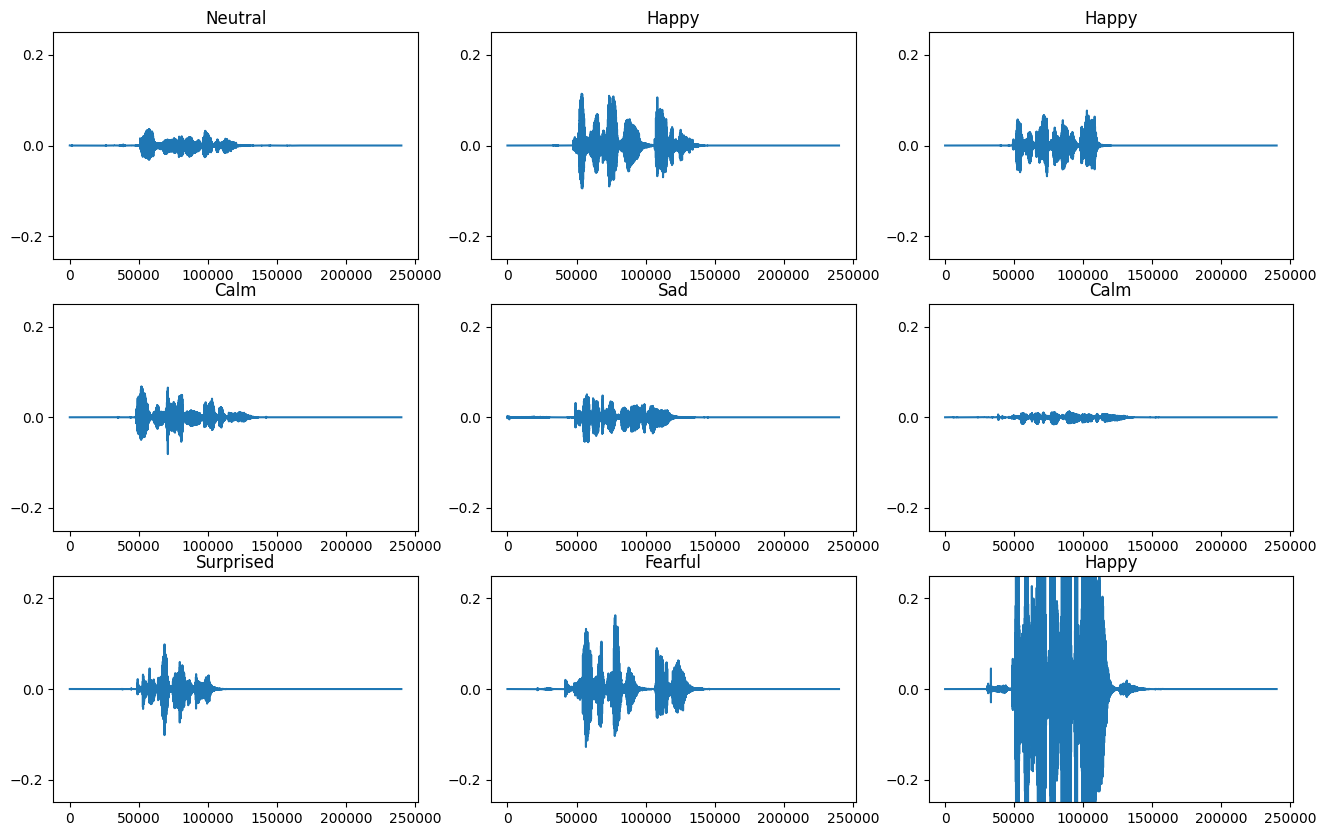

In [72]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-0.25, 0.25])

In [73]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
      waveform, frame_length=1024, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [55]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=48000))

Label: Neutral
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: Happy
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: Happy
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


In [56]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

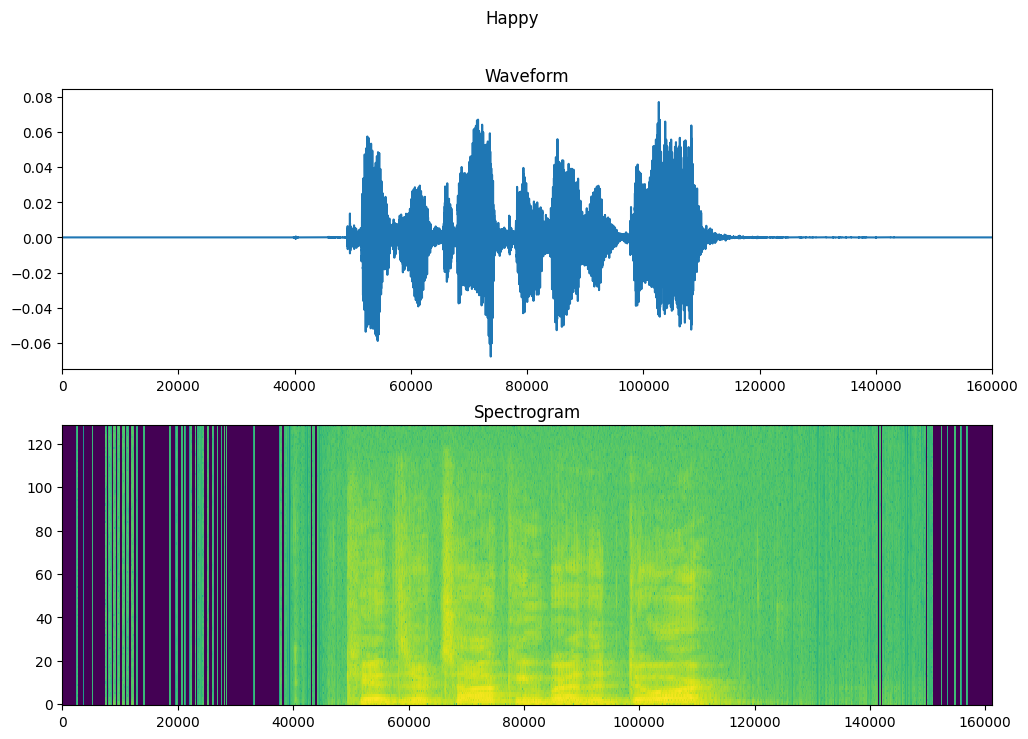

In [57]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 160000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [58]:
def make_spec_ds(ds):
  return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

In [59]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [60]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

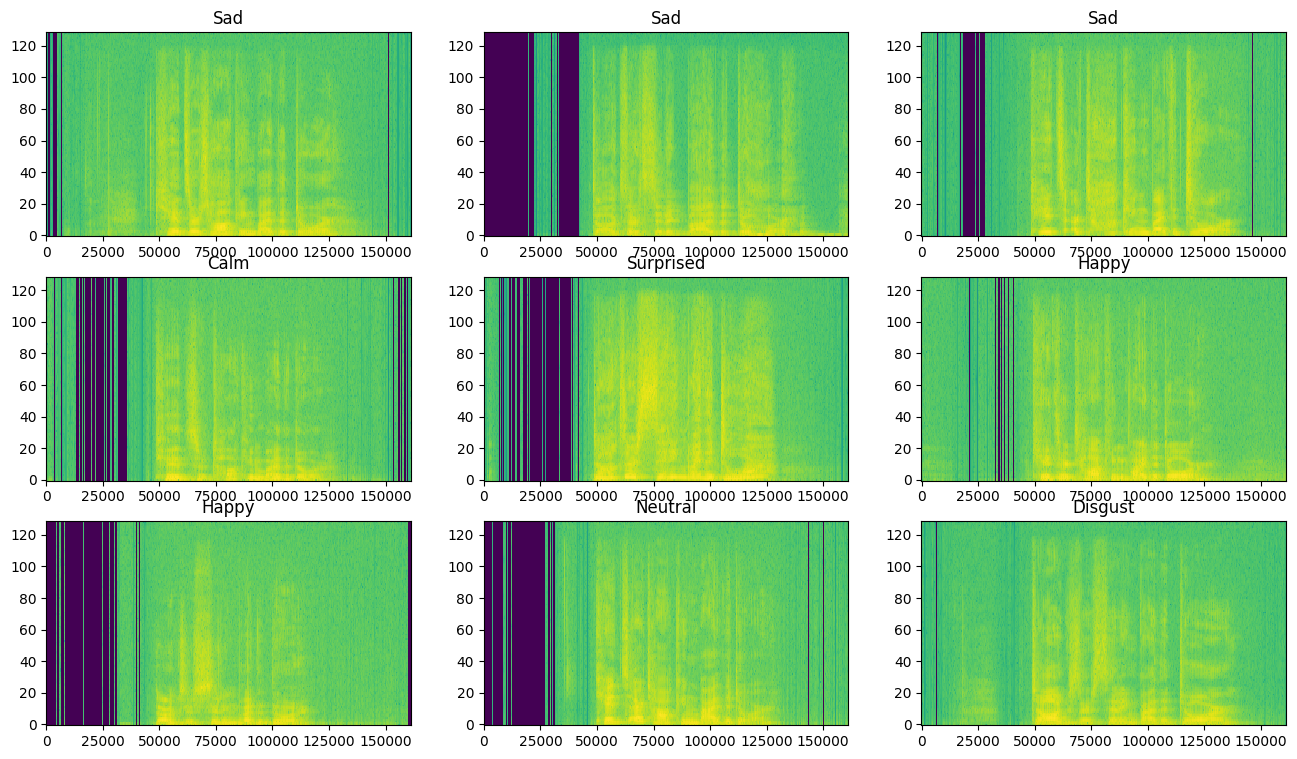

In [61]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [62]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [63]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
# norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    # norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1249, 129, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 1247, 127, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1245, 125, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 622, 62, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 622, 62, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2468096)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │     315,916,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,936,264 (1.18 GB)

 Trainable params: 315,936,264 (1.18 GB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [65]:
EPOCHS = 1
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start

  File "C:\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Python311\Lib\asyncio\events.py", line 80, in _run

  File "C:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue

  File "C:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one

  File "C:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell

  File "C:\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell

  File "C:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\Varun\AppData\Local\Temp\ipykernel_15236\965699855.py", line 2, in <module>

  File "C:\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 325, in fit

  File "C:\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

Cannot batch tensors with different shapes in component 0. First element had shape [160000,1] and element 30 had shape [160000,2].
	 [[{{node IteratorGetNext}}]] [Op:__inference_one_step_on_iterator_6376]

In [218]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

NameError: name 'history' is not defined